<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/anomaly_detection_using_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 14th Oct, 2023
# Anomaly detection for time series data
# Data Sources: https://github.com/numenta/NAB/tree/master

In [ ]:
# Code from: https://www.geeksforgeeks.org/anomaly-detection-in-time-series-data/

In [39]:
# Call libraries
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt


In [40]:
# Our data on github:

dataPath = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/ambient_temperature_system_failure.csv"

In [41]:
# Read data
data = pd.read_csv(dataPath)
data.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [42]:
# Exclude datetime column
data_values = data.drop('timestamp', axis=1).values
data_values.shape  # (7267, 1)

(7267, 1)

In [43]:
# Convert data to float type
data_values = data_values.astype('float32')

# Create new dataframe with converted values
data_converted = pd.DataFrame(data_values,
							                columns=data.columns[1:]
                              )
data_converted.head()

,value
0,69.880836
1,71.220230
2,70.877808
3,68.959396
4,69.283554


In [44]:
# Add back datetime column
data_converted.insert(0,
                      'timestamp',
					             data['timestamp']
                      )
data_converted.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880836
1,2013-07-04 01:00:00,71.220230
2,2013-07-04 02:00:00,70.877808
3,2013-07-04 03:00:00,68.959396
4,2013-07-04 04:00:00,69.283554


In [45]:
# Drop any na
data_converted = data_converted.dropna()
data_converted.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880836
1,2013-07-04 01:00:00,71.220230
2,2013-07-04 02:00:00,70.877808
3,2013-07-04 03:00:00,68.959396
4,2013-07-04 04:00:00,69.283554


In [46]:
# Transform to tensor
#  Exclude datetime column again
data_tensor = tf.convert_to_tensor(
                                   data_converted.drop( 'timestamp', axis=1).values,
                                   dtype=tf.float32
                                   )
data_tensor.shape

TensorShape([7267, 1])

In [47]:
data_tensor[:5]

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[69.88084 ],
       [71.22023 ],
       [70.87781 ],
       [68.9594  ],
       [69.283554]], dtype=float32)>

## Our model

In [48]:
input_dim = data_converted.shape[1] - 1
input_dim  # 1

1

In [49]:
# Define the autoencoder model
input_dim = data_converted.shape[1] - 1
encoding_dim = 10   # Ist hidden layer
input_layer = Input(shape=(input_dim,))





In [50]:
# Encoder/Decoder
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder) # Output dim is 1


In [51]:
# Model
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_4 (Dense)             (None, 10)                20        
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 31 (124.00 Byte)
Trainable params: 31 (124.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


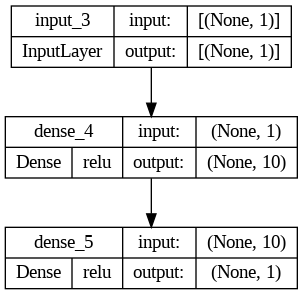

In [52]:
# Plot of model
plot_model(autoencoder,
           show_shapes= True,
           show_layer_activations = True )

In [53]:
# Compile
autoencoder.compile(optimizer='adam', loss='mse')


In [54]:
# Fit the model
autoencoder.fit(data_tensor,
                data_tensor,
                epochs=50,
				        batch_size=32,
                shuffle=True
                )

Epoch 1/50
228/228 [==============================] - 2s 3ms/step - loss: 1964.2531
Epoch 2/50
228/228 [==============================] - 1s 3ms/step - loss: 110.1496
Epoch 3/50
228/228 [==============================] - 1s 3ms/step - loss: 0.6940
Epoch 4/50
228/228 [==============================] - 1s 3ms/step - loss: 0.0030
Epoch 5/50
228/228 [==============================] - 1s 2ms/step - loss: 0.0026
Epoch 6/50
228/228 [==============================] - 1s 2ms/step - loss: 0.0026
Epoch 7/50
228/228 [==============================] - 1s 2ms/step - loss: 0.0026
Epoch 8/50
228/228 [==============================] - 1s 2ms/step - loss: 0.0026
Epoch 9/50
228/228 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 10/50
228/228 [==============================] - 1s 2ms/step - loss: 0.0026
Epoch 11/50
228/228 [==============================] - 1s 3ms/step - loss: 0.0026
Epoch 12/50
228/228 [==============================] - 1s 2ms/step - loss: 0.0026
Epoch 13/50
228/228 

In [57]:
# Calculate the reconstruction error for each data point
reconstructions = autoencoder.predict(data_tensor)
reconstructions[:5]


228/228 [==============================] - 1s 4ms/step


array([[69.897606],
       [71.2257  ],
       [70.88616 ],
       [68.98395 ],
       [69.30537 ]], dtype=float32)

In [60]:
mse = tf.reduce_mean(
                     tf.square(data_tensor - reconstructions),
                     axis=1
                     )

mse.shape  # 7267

TensorShape([7267])

In [61]:
anomaly_scores = pd.Series(
                            mse.numpy(),
                            name='anomaly_scores'
                            )
anomaly_scores[:5]

0    0.000281
1    0.000030
2    0.000070
3    0.000603
4    0.000476
Name: anomaly_scores, dtype: float32

In [62]:
anomaly_scores.index = data_converted.index
anomaly_scores[:5]

0    0.000281
1    0.000030
2    0.000070
3    0.000603
4    0.000476
Name: anomaly_scores, dtype: float32

In [63]:
threshold = anomaly_scores.quantile(0.99)
threshold


0.009300276823341851

In [66]:
anomalous = anomaly_scores > threshold
anomalous[:5]

0    False
1    False
2    False
3    False
4    False
Name: anomaly_scores, dtype: bool

In [ ]:
# Label
binary_labels = anomalous.astype(int)
precision, recall,f1_score, _ = precision_recall_fscore_support(binary_labels,
                                                                anomalous,
                                                                average='binary'
                                                                )

In [21]:
test = data_converted['value'].values
predictions = anomaly_scores.values

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)


Precision:  1.0
Recall:  1.0
F1 Score:  1.0


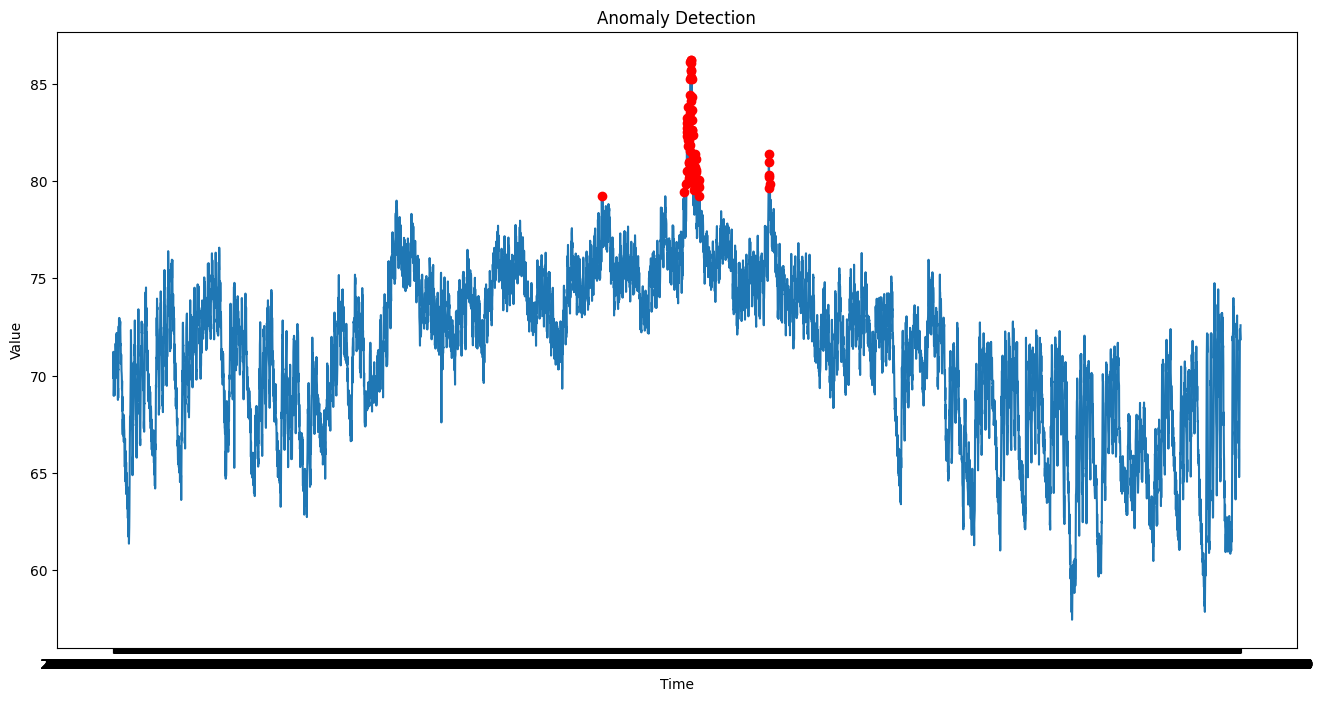

In [22]:
# Plot the data with anomalies marked in red
plt.figure(figsize=(16, 8))
plt.plot(data_converted['timestamp'], data_converted['value'])
plt.plot(data_converted['timestamp'][anomalous], data_converted['value'][anomalous], 'ro')
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()
